 # Black-Hole Binary Formation Channels with Gaussian Mixtures 

Many problems in astrophysics give rise to data with multiple modes. This is typically because different physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamic assembly of sources in dense environments like globular clusters.


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)

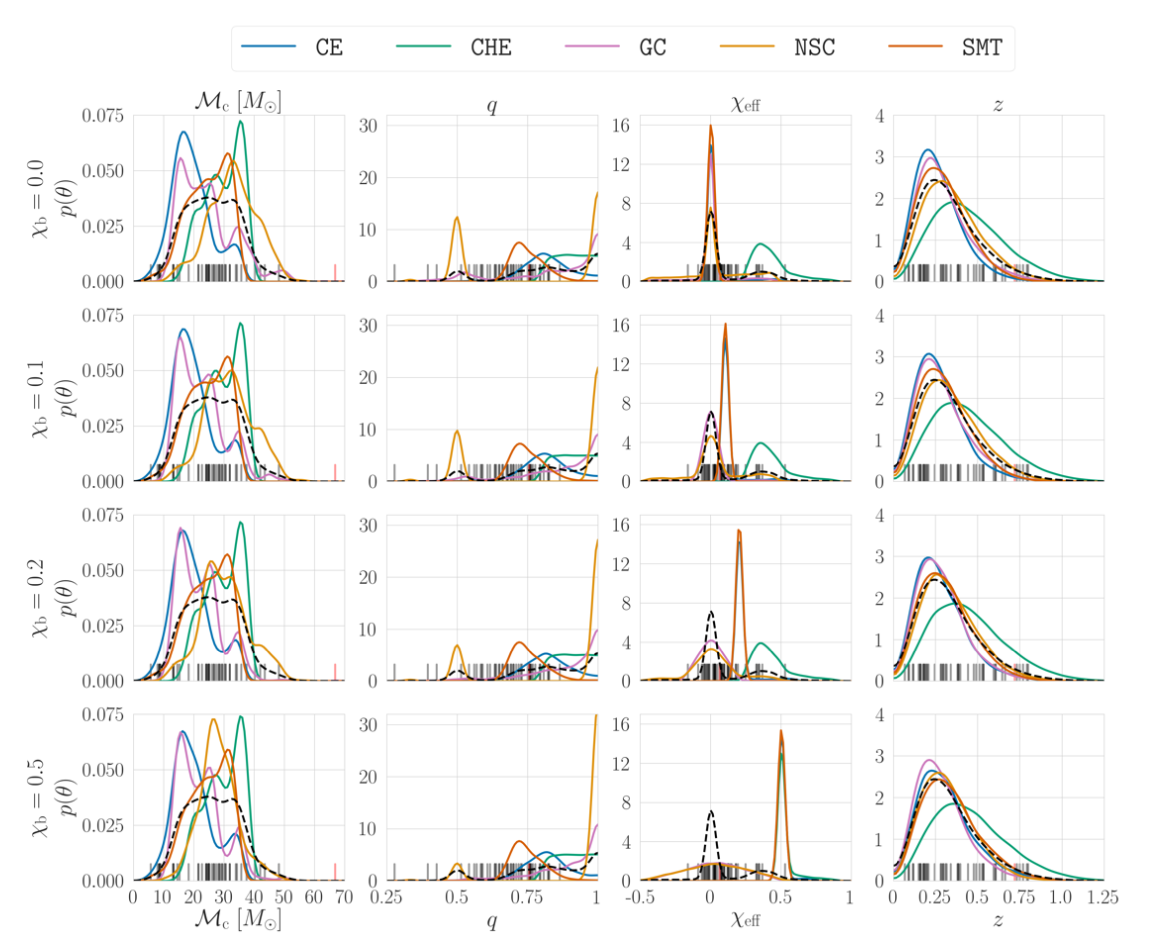

where they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).


Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.


### Class labels or "responsibilities"

Class labels are a very interesting by products of a mixture analysis.

What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data). 

$p(j|x_i) = \frac{a_j \mathcal{N(\mu_j,\sigma_j)}}{\sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j)}$


#### At home: derive this using Bayes' rule

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import seaborn as sns
sns.set_style('whitegrid')

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)

/home/ario/anaconda3/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
data = np.load('../solutions/formationchannels.npy')

### Look at the data

Text(0.5, 1.0, 'Formation Channels')

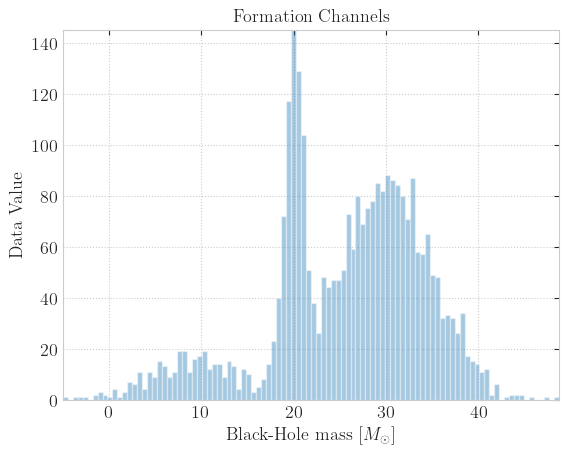

In [4]:
plt.hist(data, bins=100, alpha=0.4)
plt.xlabel(r'Black-Hole mass [$M_\odot$]')
plt.ylabel('Data Value')
plt.title('Formation Channels')

My guess: **3 Gaussian distribution**

## Gaussian fit
Let's try to fit our data with Gaussian Mixtures with different N (from 1 to 10).

In [8]:
N = np.arange(2, 11)

In [9]:
my_models = [None for i in range(len(N))]

for i in range(len(N)):
    my_models[i] = GaussianMixture(N[i]).fit(data)

In [10]:
my_models

[GaussianMixture(n_components=2),
 GaussianMixture(n_components=3),
 GaussianMixture(n_components=4),
 GaussianMixture(n_components=5),
 GaussianMixture(n_components=6),
 GaussianMixture(n_components=7),
 GaussianMixture(n_components=8),
 GaussianMixture(n_components=9),
 GaussianMixture(n_components=10)]

## Compute the AIC

In [11]:
AIC = [model.aic(data) for model in my_models]

Text(0.5, 1.0, 'Akaike Information Criterion (AIC)')

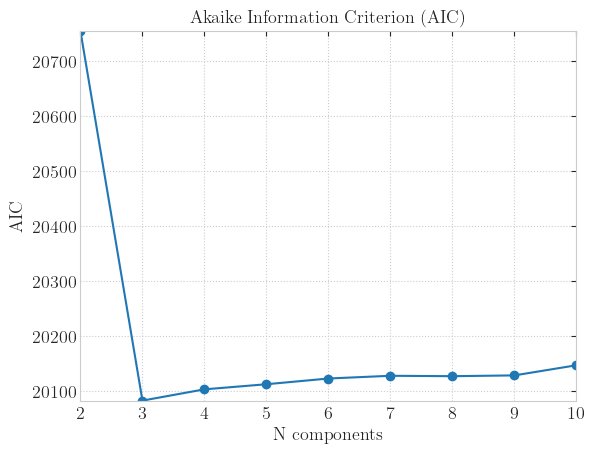

In [12]:
plt.plot(N, AIC, marker='o')
plt.xlabel('N components')
plt.ylabel('AIC')
plt.title('Akaike Information Criterion (AIC)')

In [13]:
print('The AIC is minimum for N = ', N[np.argmin(AIC)])

The AIC is minimum for N =  3


My assumption was correct, so I can try to fit the data with a **3-Gaussians Mixture**

In [14]:
best_model = my_models[np.argmin(AIC)]

In [15]:
x_i = np.linspace(0, 60, 1000)

# Ln of the probability for each point in x_i using the score_samples method
logprob = best_model.score_samples(x_i.reshape(-1,1))

# Get the probabilities
pdf = np.exp(logprob)

# Weights, mean and std of the Gaussian Components
wts, mus, sigmas = best_model.weights_.flatten(), best_model.means_.flatten(), np.sqrt(best_model.covariances_.flatten())

In [16]:
mus, sigmas, wts

(array([30.12430964,  9.09213997, 20.05198472]),
 array([4.91058656, 4.66870785, 1.06644558]),
 array([0.66935985, 0.11623429, 0.21440586]))

In [17]:
# the function takes in a series of points, the parameters of the Gaussians, 
# and their respective weights, and returns the combined density of the mixture.

def MixedGaussians(x, loc, scale, weights):
    
    distrib = np.zeros(len(x))
    
    for mu, sigma, pi in zip(loc, scale, weights):
        distrib += pi * norm.pdf(x, loc=mu, scale=sigma)
        
    return distrib

In [18]:
mixedgaussians = MixedGaussians(x_i, mus, sigmas, wts) 

Text(0.5, 1.0, 'Gaussian Mixture')

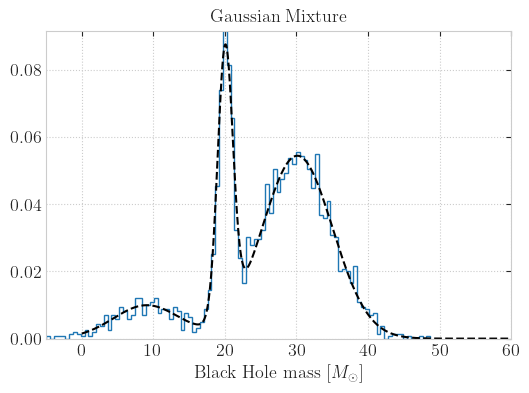

In [19]:
plt.figure(figsize=(6,4))

plt.hist(data, bins=100, density=True, histtype='step', label='Data')
plt.plot(x_i, mixedgaussians, color='black', linestyle='--')
plt.xlabel(r'Black Hole mass $\left[M_\odot\right]$ ')
plt.title('Gaussian Mixture')

Let's now figure out the single components!

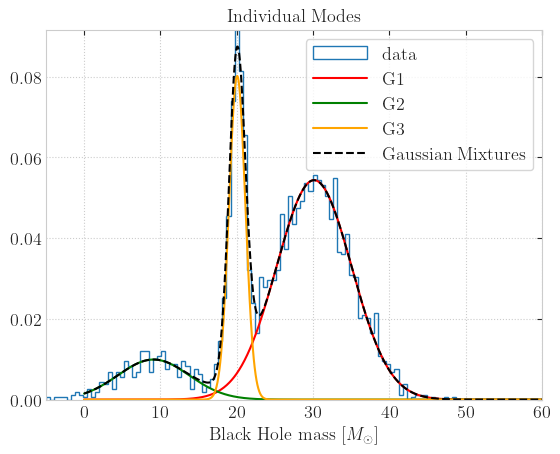

In [20]:
responsibilities = best_model.predict_proba(x_i.reshape(-1, 1))
pdf_individual   = responsibilities * pdf[:, np.newaxis]

plt.hist(data, bins=100, density=True, histtype='step', label='data')
plt.plot(x_i, pdf_individual[:,0], c='red', label='G1')
plt.plot(x_i, pdf_individual[:,1], c='green', label='G2')
plt.plot(x_i, pdf_individual[:,2], c='orange', label='G3')
plt.plot(x_i, pdf, '--k', label='Gaussian Mixtures')

plt.xlabel(r'Black Hole mass $[M_\odot]$')
plt.title('Individual Modes')
plt.legend()

### Compare the N = 3 and the N = 4 model

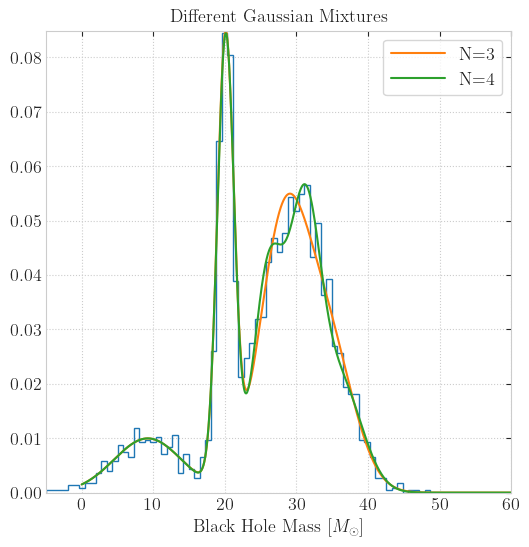

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.hist(data, 70, density=True, histtype='step')

logprob_3g = my_models[2].score_samples(x_i.reshape(-1,1))
logprob_4g = my_models[3].score_samples(x_i.reshape(-1,1))
logprob_5g = my_models[4].score_samples(x_i.reshape(-1,1))


plt.plot(x_i, np.exp(logprob_3g), label='N=3')
plt.plot(x_i, np.exp(logprob_4g), label='N=4')
plt.title('Different Gaussian Mixtures')
plt.xlabel(r'Black Hole Mass $[M_\odot]$')
plt.legend()

It seems that the GMM with 4 gaussians better fits the data, in particular in the 'third' mode of the distribution.

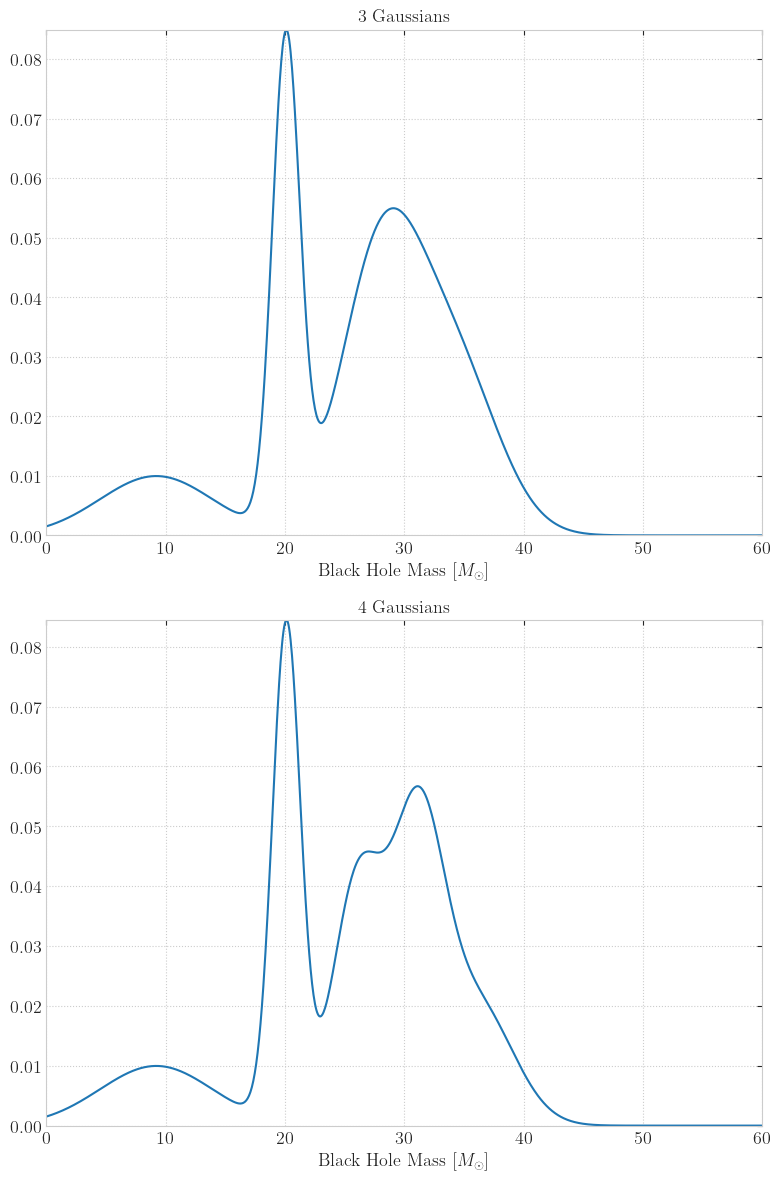

In [30]:
fig, ax = plt.subplots(2, figsize=(8, 12))
ax[0].plot(x_i, np.exp(logprob_3g) )
ax[0].set_xlabel(r'Black Hole Mass $[M_\odot]$')
ax[0].set_title('3 Gaussians')
ax[1].plot(x_i, np.exp(logprob_4g) )
ax[1].set_xlabel(r'Black Hole Mass $[M_\odot]$')
ax[1].set_title('4 Gaussians')

plt.tight_layout()


### BIC Criterium

In [31]:
BIC = [model.bic(data) for model in my_models]

Text(0.5, 1.0, 'Bayesian Information Criterion (BIC)')

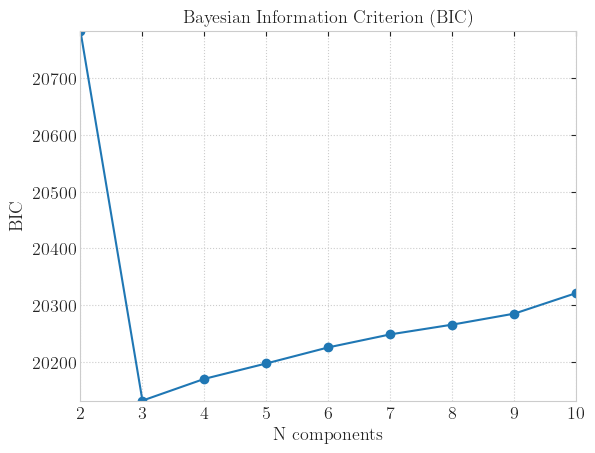

In [32]:
plt.plot(N, BIC, marker='o')
plt.xlabel('N components')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion (BIC)')